In [139]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from itertools import permutations

import py4DSTEM
from py4DSTEM.process.utils import get_maxima_2D
from py4DSTEM.file.datastructure import PointListArray
from py4DSTEM.process.utils import add_to_2D_array_from_floats

from py4DSTEM.process.classification import get_braggpeak_labels_by_scan_position, get_initial_classes
from py4DSTEM.process.utils import get_voronoi_vertices

In [2]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
#fp = "/Users/Ben/Desktop/EASY_binDiffraction4_no_datacube.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

Q_Nx, Q_Ny = deconvolution.shape
R_Nx,R_Ny = ave_im.shape

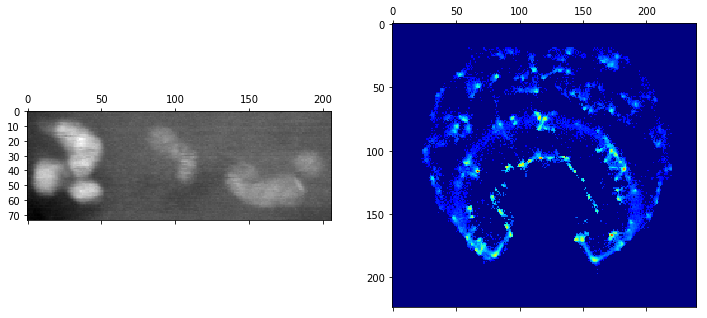

In [3]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

#### Get bragg peaks sets at each scan position

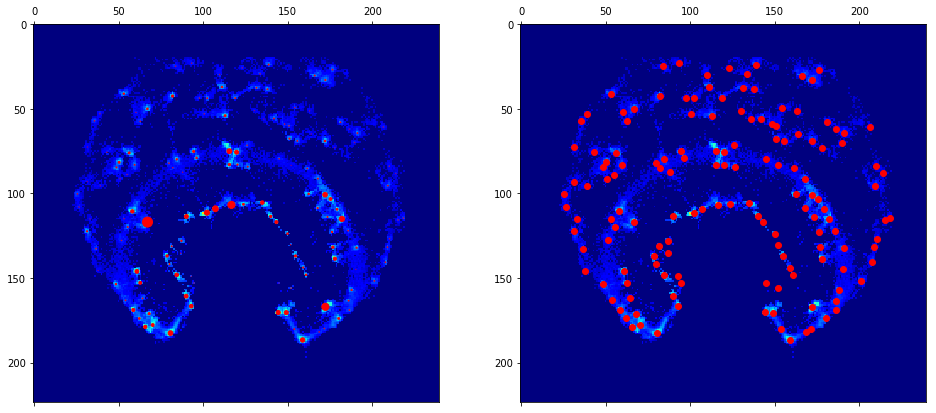

In [4]:
# Get deconvolution maxima

sigma = 1
edgeBoundary = 0
minSpacing = 0
minRelativeIntensity = 0.0005
relativeToPeak = 0
maxNumPeaks = 0
subpixel = True

power = 0.25
scale = 100

maxima_x, maxima_y, maxima_int = get_maxima_2D(deconvolution, sigma=sigma, edgeBoundary=edgeBoundary,
                                               minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                               relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks,
                                               subpixel=subpixel)
N = len(maxima_x)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='r',
            s=scale*maxima_int/np.max(maxima_int))
ax2.matshow(deconvolution**power,cmap='jet')
ax2.scatter(maxima_y,maxima_x,color='r')
plt.show()

In [5]:
# Get the sets of Bragg peaks present at each scan position

braggpeak_labels = get_braggpeak_labels_by_scan_position(braggpeaks,maxima_x,maxima_y)

#### Show Voronoi diagram

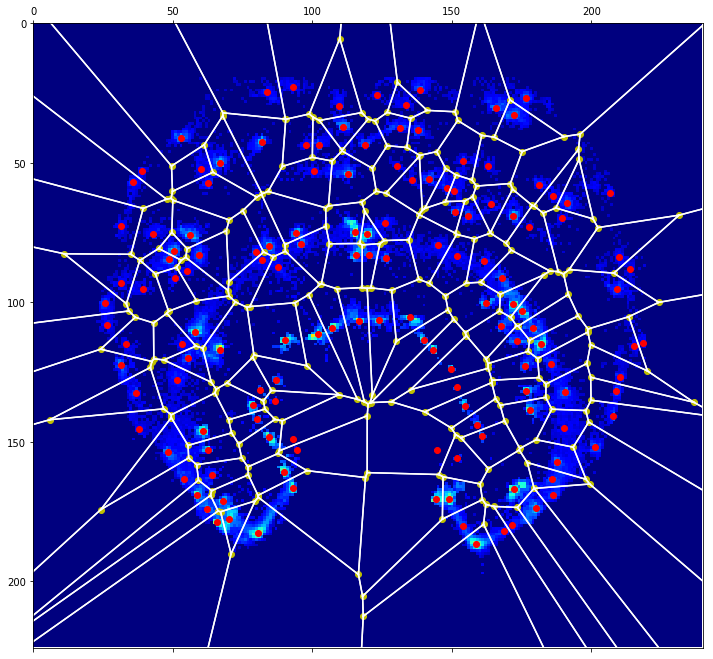

In [6]:
# Make a Voronoi diagram
points = np.vstack((maxima_x,maxima_y)).T
voronoi = Voronoi(points)

# Get vertices
vertices = get_voronoi_vertices(voronoi, Q_Nx, Q_Ny)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')
for region in range(len(vertices)):
    vertices_curr = vertices[region]
    for i in range(len(vertices_curr)):
        x0,y0 = vertices_curr[i,:]
        x1,y1 = vertices_curr[(i+1)%len(vertices_curr),:]
        ax.plot((y0,y1),(x0,x1),'w')        
ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
plt.gca().invert_yaxis()
plt.show()

#### Get initial classes

In [7]:
thresh = 0.3
BP_fraction_thresh = 0.1
max_iterations = 200

BP_sets = get_initial_classes(braggpeak_labels, N=N, thresh=thresh, BP_fraction_thresh=BP_fraction_thresh,
                                                                    max_iterations=max_iterations)

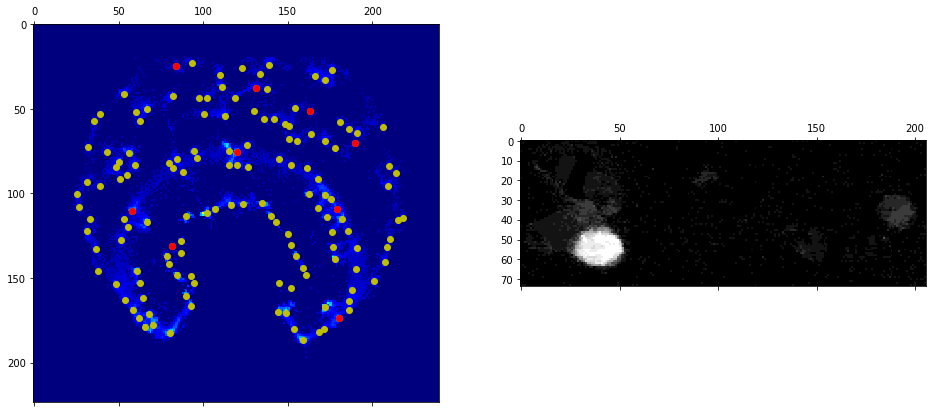

In [182]:
index = 1

class_BP_set = BP_sets[index]
class_map = np.zeros((R_Nx,R_Ny))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        s = braggpeak_labels[Rx][Ry]
        class_map[Rx,Ry] = len(s.intersection(class_BP_set))/len(class_BP_set)


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
ax1.scatter(maxima_y,maxima_x,color='y')
for i in BP_set:
    ax1.scatter(maxima_y[i],maxima_x[i],color='r')
ax1.grid(False)
ax2.matshow(class_map)
ax2.grid(False)
plt.show()

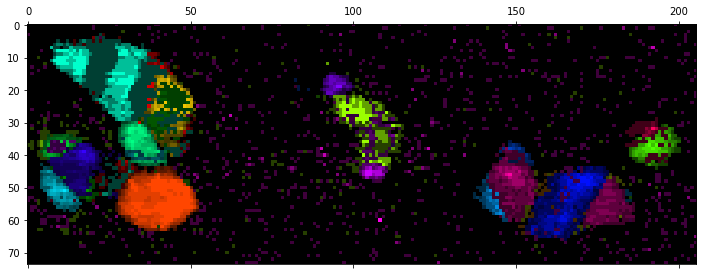

In [107]:
# Plot overlay

thresh = 0.4
cmap_base = get_cmap('hsv')

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(np.zeros((R_Nx,R_Ny)))

for index in range(len(BP_sets)):
    BP_set = BP_sets[index]
    class_map = np.zeros((R_Nx,R_Ny))
    for Rx in range(R_Nx):
        for Ry in range(R_Ny):
            s = braggpeak_labels[Rx][Ry]
            class_map[Rx,Ry] = len(s.intersection(BP_set))/len(BP_set)
    ma = np.ma.array(class_map, mask = class_map<thresh)

    #colors = [(0,0,0,1),cmap_base(index/len(BP_sets))]
    c1 = cmap_base(index/len(BP_sets))
    c0 = (c1[0]/4.,c1[1]/4.,c1[2]/4.,1)
    colors = [c0,c1]
    cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
    ax.matshow(ma,cmap=cm)

plt.show()

#### Non-negative matrix factorization

In [108]:
from sklearn.decomposition import NMF

In [359]:
# Construct relevant matrices: X = WH
# X is the data matrix
# W is the feature matrix
# H is the weighting matrix

bools = False   # X matrix includes BP intensities, or just if a BP is present or not


# X - shape (#BPs, #classes). Column i gives the Bragg peaks intensities at scan position i

X = np.zeros((N,R_Nx*R_Ny))
for Rx in range(R_Nx):
    for Ry in range(R_Ny):
        R = Rx*R_Ny + Ry
        s = braggpeak_labels[Rx][Ry]
        pointlist = braggpeaks.get_pointlist(Rx,Ry)
        for i in s:
            if bools is True:
                X[i,R] = 1
            else:
                qx,qy = maxima_x[i],maxima_y[i]
                ind = np.argmin(np.hypot(pointlist.data['qx']-qx,pointlist.data['qy']-qy))
                X[i,R] = pointlist.data['intensity'][ind]
            
            
# W - shape (#BPs, #classes). Each column is a class, containing the weightings for the BPs in the class
W = np.zeros((N, len(BP_sets)))
for i in range(len(BP_sets)):
    BP_set = BP_sets[i]
    for j in BP_set:
        W[j,i] = 1

# H - shape (#classes, #scan positions). Column i specifies the weights of each class contributing to scan position i
H = lstsq(W,X,rcond=None)[0]
H = np.where(H<0,0,H)


In [360]:
max_iter = 5

nmf = NMF(n_components=len(BP_sets), init='custom', max_iter=max_iter)

In [361]:
W = nmf.fit_transform(X, W=W, H=H)
H = nmf.components_

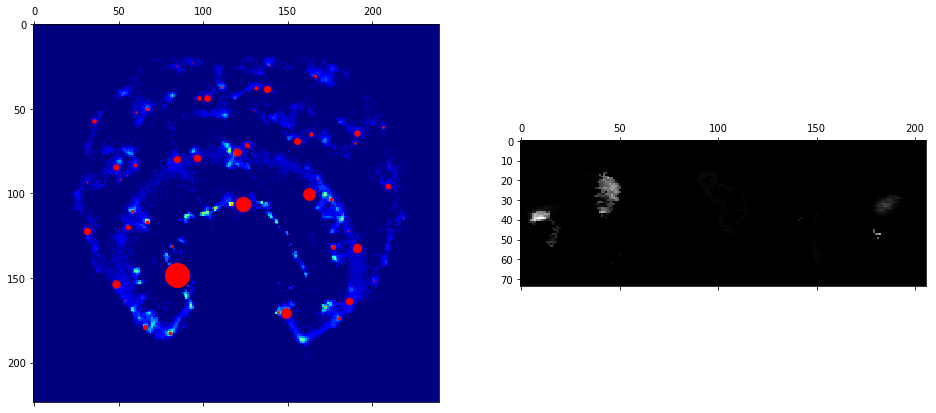

In [367]:
# Show classes

class_index = 8
sizescale = 100

BP_vals = W[:,class_index]
R_vals = H[class_index,:]

class_map = R_vals.reshape((R_Nx,R_Ny))
# class_map = np.zeros((R_Nx,R_Ny))
# for Rx in range(R_Nx):
#     for Ry in range(R_Ny):
#         class_map[Rx,Ry] = R_vals[Ry*R_Nx+Rx]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**power,cmap='jet')
#ax1.scatter(maxima_y,maxima_x,color='y')
for i in range(N):
    ax1.scatter(maxima_y[i],maxima_x[i],color='r',s=sizescale*BP_vals[i])
ax1.grid(False)
ax2.matshow(class_map)
ax2.grid(False)
plt.show()

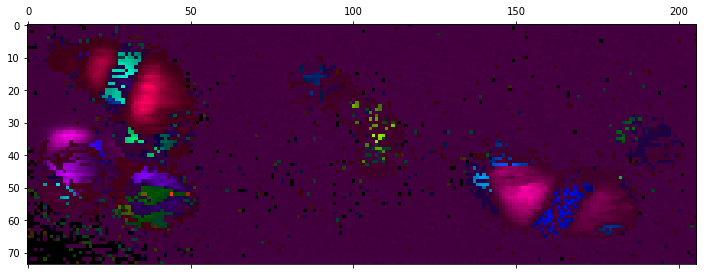

In [340]:
# Plot overlay

thresh = 0.4
cmap_base = get_cmap('hsv')

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(np.zeros((R_Nx,R_Ny)))

for index in range(len(BP_sets)):
    R_vals = H[index,:]
    class_map = R_vals.reshape((R_Nx,R_Ny))
    ma = np.ma.array(class_map, mask = class_map<thresh)

    #colors = [(0,0,0,1),cmap_base(index/len(BP_sets))]
    c1 = cmap_base(index/len(BP_sets))
    c0 = (c1[0]/4.,c1[1]/4.,c1[2]/4.,1)
    colors = [c0,c1]
    cm = LinearSegmentedColormap.from_list('cmap', colors, N=100)
    ax.matshow(ma,cmap=cm)

plt.show()

In [8]:
class ClassLabel(object):
    """
    The ClassLabel object contains data pertaining to a single classified region of real space.
    It is a python class used to classify space into k classes; a class class, if you will. So classy!
    Isn't overloaded language fun?
    
    This labels scan positions.  That is, this object specifies some sub-region of a 2D array (as a boolean array,
    self.mask) whose associated diffraction patterns are understood to be the constituents of this class.  Physically,
    each class is understood to correspond to a set of Bragg peaks; the relationship between these peaks in Q-space,
    and the relationship between these peaks and the diffraction patterns themselves, is left formally unspecified.
    
    Let there be a total of N Bragg peaks which have been detected in all DPs.  The class then contains the attributes
    y and w, which are length N vectors specifying the relationships of the Bragg peaks to the class: y is Boolean,
    with y[i] indicating if the i'th Bragg peak is considered to be associated with this class; w is a real number
    in [0,1], with w[i] indicated the strength of the association of the i'th Bragg peak with the class.
    
    For some diffraction pattern, let x be a length N Boolean vector, with x[i] indicating if the i'th Bragg peaks is
    contained in the DP.  We deem the DP to be more likely to be a member of the class if it minimizes the cost function
    
        $   c = - \sum_i(x_i y_i w_i) + V\sum_i(x_i \logical_xor y_i)   $ 
    
    where V idicates how strongly we penalize the DP and the class having differing Bragg peaks.
    
    Summarizing the relevant quantities:
         x              (length N array of bools) self.x[i] is True if $i\in s$, i.e. if the i'th BP is in this DP
         self.y         (length N array of bools) self.y[i] is True if the i'th DP is associated with this class
         self.w         (length N array of floats) self.w[i] quantifies the strength with which we associate the
                                                   i'th DP with the class.
         self.V         (int) how strongly we penalize x and y having differing Bragg peaks
         
    The quantities are determined as follows:
        x               Initially, Bragg peaks are found using cross-correlation with a template vaccuum probe kernel.
                        Indexes are assigned to the Bragg peaks according to their regions in a Voronoi tesselation
                        seeded with the maxima of the average deconvolution.  The boolean vector x for some DP is then
                        constucting by setting x[i]=True whenever one of the Bragg peaks found in this DP was found to
                        have index i.
        self.y          Set using a simple threshold with respect to self.w.  self.y[i] is True whenever
                        self.w[i] > self.thresh.
        self.w          The fraction of the class DPs containing each Bragg peak.
        self.V          User specified.
        self.thresh     User specified.
         
    A ClassLabel must be initialized with some starting scan positions, by specifying a 2D Boolean realslice-shaped
    mask.  This is used to construct and initialize self.y, and self.w.
    """    
    def __init__(self, index, mask, V, thresh, 
                        braggpeak_labels, N, R_Nx, R_Ny):
        """
        Initialize a ClassLabel object. 
        
        Accepts:
            index               (int) the class index
            mask                (2D array of bools) initial scan positions to include
            V                   (float) scales penalty for nonoverlapped Bragg peaks
            thresh              (float) min value of self.w[i] at which self.y[i] is set to True
            braggpeak_labels    (list of lists of sets) the indices of the Bragg peaks found at each scan position
            N                   (int) the total number of indexed BPs
            R_Nx                (int) x scan shape
            R_Ny                (int) y scan shape
        """
        # Class parameters
        self.index = index
        self.mask = np.zeros((R_Nx,R_Ny),dtype=bool)
        self.V = V
        self.thresh = thresh
        self.braggpeak_labels = braggpeak_labels
        self.N = N
        self.y = np.zeros(self.N,dtype=bool)
        self.w = np.zeros(self.N,dtype=float)
        
        # Machinery
        self.counts_per_BP = np.zeros(self.N,dtype=int)
        self.N_DP = 0
        self.cost = 0
        
        # Add initial points
        rx,ry = np.nonzero(mask)
        self.add_data_by_scan_position(rx,ry)
        return

    def add_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if not self.mask[rx,ry]:
                self.mask[rx,ry] = True
                self.N_DP += 1
                s = self.braggpeak_labels[rx][ry]
                for i in s:
                    self.counts_per_BP[i] += 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if not self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = True
                    self.N_DP += 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] += 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def remove_data_by_scan_position(self,rx,ry):
        if isinstance(rx,(int,np.integer)) and isinstance(ry,(int,np.integer)):
            if self.mask[rx,ry]:
                self.mask[rx,ry] = False
                self.N_DP -= 1
                s = braggpeak_sets[rx][ry]
                for i in s:
                    self.counts_per_BP[i] -= 1
        else:
            assert len(rx)==len(ry)
            for j in range(len(rx)):
                if self.mask[rx[j],ry[j]]:
                    self.mask[rx[j],ry[j]] = False
                    self.N_DP -= 1
                    s = braggpeak_sets[rx[j]][ry[j]]
                    for i in s:
                        self.counts_per_BP[i] -= 1
        self.get_w()
        self.get_y()
        self.get_cost()
        
    def get_w(self):
        self.w = self.counts_per_BP.astype(float)/self.N_DP
        
    def get_y(self):
        self.y = self.w > self.thresh
        
    def get_cost_of_set(self,s):
        """
        Computes the cost of adding a DP containing set s of Bragg peak indices to the class, using the current state
        of self.y and self.w.
        """
        if self.N_DP==0:
            return 0
        x = self.s_to_array(s)
        return -np.sum(x*self.y*self.w - self.V*np.logical_xor(x,self.y))

    def get_cost(self):
        """
        Get the total cost of the ClassLabel instance.
        """
        cost = 0
        rx,ry = np.nonzero(self.mask)
        for i in range(len(rx)):
            s = braggpeak_sets[rx[i]][ry[i]]
            cost += self.get_cost_of_set(s)
        self.cost = cost
        return self.cost
    
    def s_to_array(self,s):
        """
        Converts a set of indices s to a length N Boolean array x which is True at x[i] if i is in s.
        """
        x = np.zeros(self.N,dtype=bool)
        for i in s:
            x[i] = True
        return x